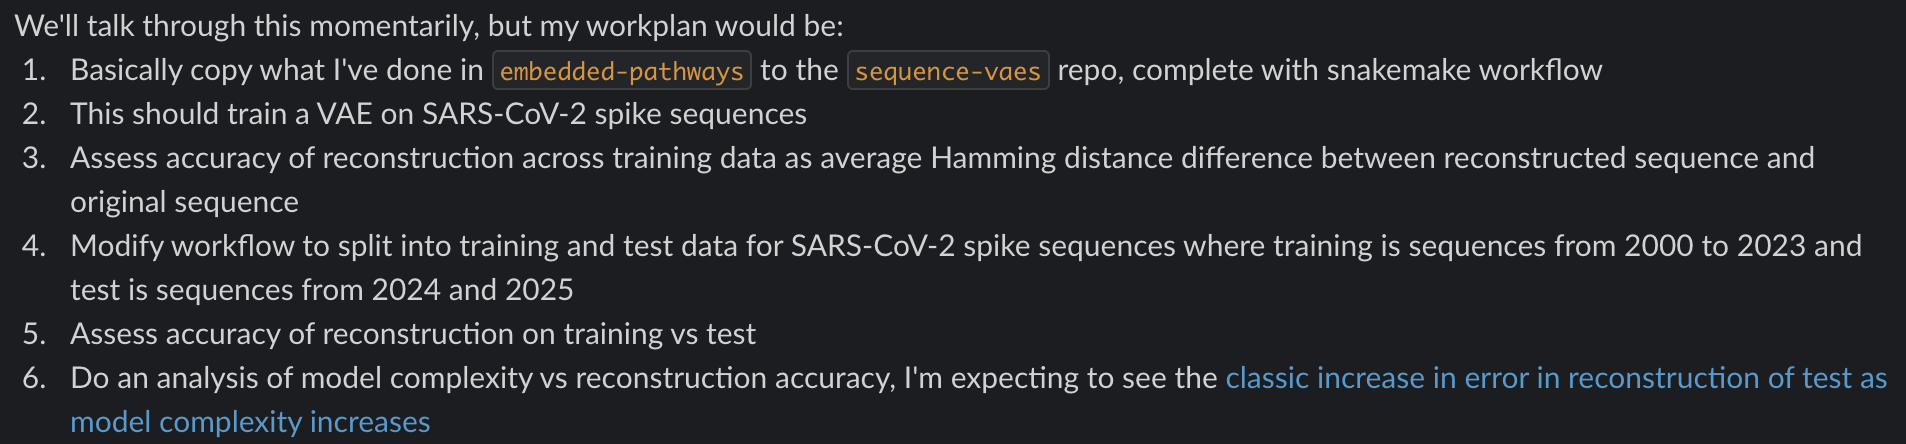

In [1]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [2]:
# path to sequence_vaes directory
# abspath = "/content/drive/MyDrive/bedford_lab/code/seq_vaes"
abspath = ".."

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys
import json
from treetime.utils import datetime_from_numeric
from collections.abc import Iterable

# path to sequence_vaes directory and pip install
# %cd "/content/drive/MyDrive/bedford_lab/code/seq_vaes"
# !pip install -r requirements.txt

In [4]:
sys.path.append(abspath)
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
import pandas as pd

import bedford_code.models_bedford as bedford
import utils

In [5]:
BATCH_SIZE = 64

# "data" directory is generated as shown in README.md file
dataset = DNADataset(f"{abspath}/data/training_spike.fasta")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## loss figures

In [7]:
train_logs = []
valid_logs = []

abspath = "./results"
# abspath = "./bedford_code/results_bedford"

N=1
with open(f"{abspath}/train_logs.json", "r") as f:
    train_logs = json.load(f)[N:]

with open(f"{abspath}/valid_logs.json","r") as f:
    valid_logs = json.load(f)[N:]

loss_X = list(range(N,len(valid_logs)+N, 1))

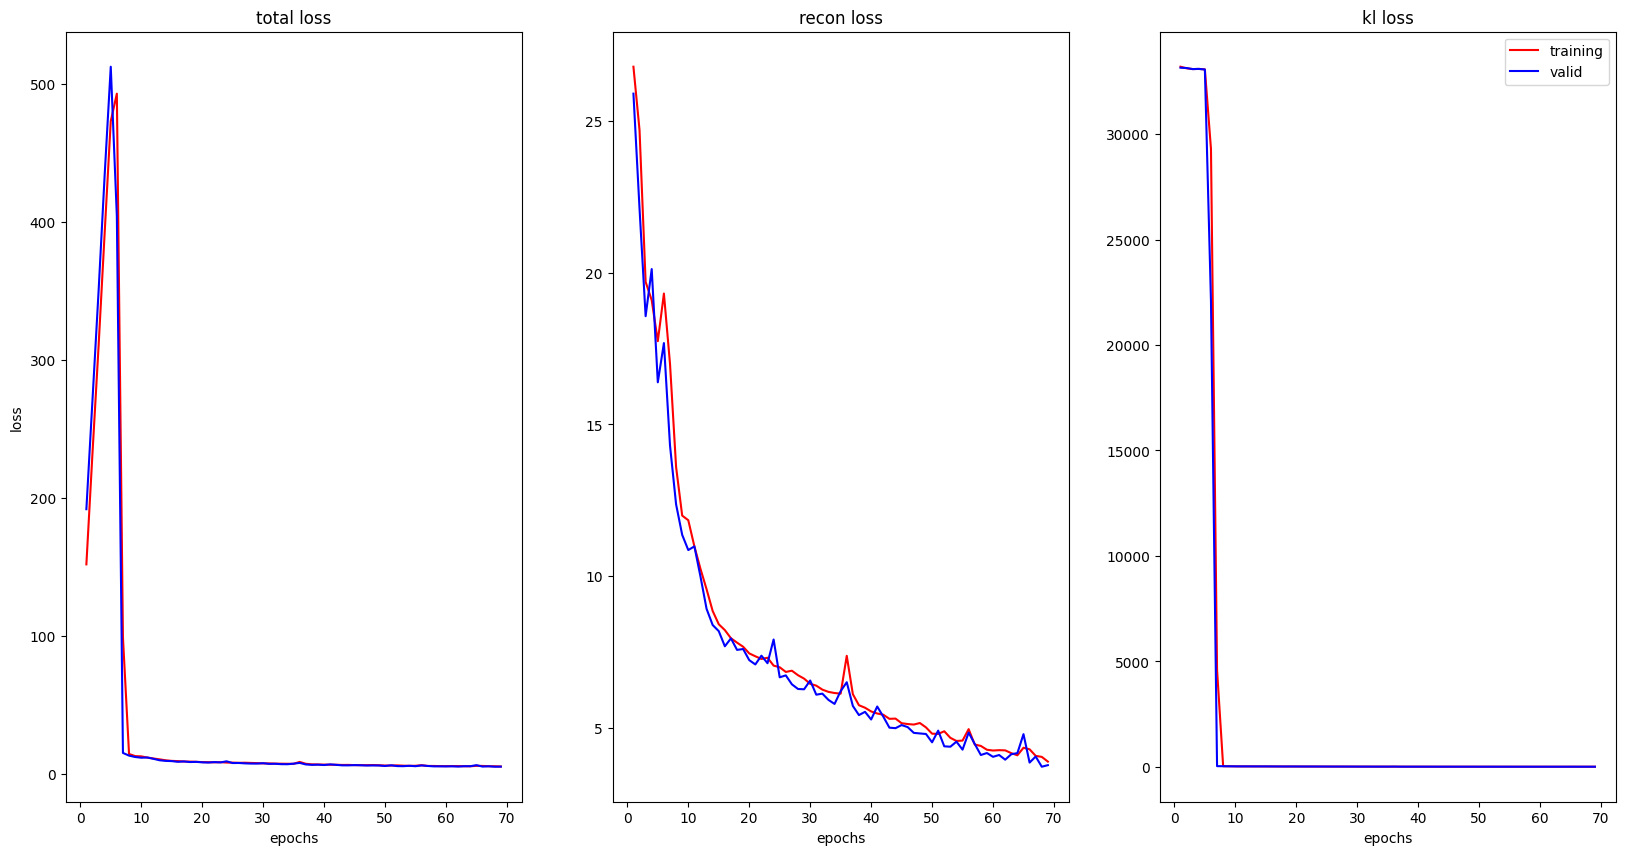

In [8]:
labels = ["total", "recon", "kl"]
colors = ["red", "blue"]

fig,arr = plt.subplots(1,3,figsize=(20,10))

N = len(train_logs)
for i in range(3):
    arr[i].plot(loss_X, [x[i] for x in train_logs], color=colors[0], label="training")
    arr[i].plot(loss_X, [x[i] for x in valid_logs], color=colors[1], label="valid")
    arr[i].set_title("%s loss"%labels[i])
    arr[i].set_xlabel("epochs")
    if i == 0:
        arr[i].set_ylabel("loss")

plt.legend()
fig.show()

## Embedding space Visualizations

In [9]:
input_dim = len(ALPHABET) * SEQ_LENGTH
# input_dim = 29903 * 5
# input_dim = 29903

# BEDFORD
# vae_model = bedford.VAE(input_dim=len(bedford.ALPHABET) * bedford.SEQ_LENGTH, latent_dim=bedford.LATENT_DIM).to(DEVICE)
# vae_model.load_state_dict(torch.load("./bedford_code/results_bedford/BEST_vae_ce_anneal.pth"))
#STANDARD
vae_model = VAE(input_dim=input_dim, latent_dim=50, non_linear_activation=nn.Softplus(beta=1.0)).to(DEVICE)
vae_model.load_state_dict(torch.load("./model_saves/standard_VAE_model_BEST.pth", weights_only=True, map_location=DEVICE))


vae_model.eval()

/home/averma2/miniforge3/envs/Moreta_env/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


VAE(
  (non_linear_activation): Softplus(beta=1.0, threshold=20)
  (encoder): Encoder(
    (non_linear_activation): Softplus(beta=1.0, threshold=20)
    (encode): Sequential(
      (0): Linear(in_features=19110, out_features=512, bias=True)
      (1): Softplus(beta=1.0, threshold=20)
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): Softplus(beta=1.0, threshold=20)
    )
    (fc_mean): Linear(in_features=256, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (non_linear_activation): Softplus(beta=1.0, threshold=20)
    (decode): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): Softplus(beta=1.0, threshold=20)
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): Softplus(beta=1.0, threshold=20)
      (4): Linear(in_features=512, out_features=19110, bias=True)
    )
  )
)

In [10]:
import utils
dset = ["training", "valid", "test"]
dset = dset[0]
abspath = ".."


# LOAD DATA
data_keys, data_dict = utils.get_data_dict(dset, abspath)
print(data_keys)
new_dataset = data_dict["new_dataset"]
vals = data_dict["vals"]
metadata = data_dict["metadata"]
clade_labels = data_dict["clade_labels"]
collection_dates = data_dict["collection_dates"]
indexes = data_dict["indexes"]
pairs = data_dict["pairs"]
get_parents_dict = data_dict["get_parents_dict"]

collection_dates
 [21, 54, 67, 86, 108, 140, 154, 187, 206, 220, 240, 257, 264, 275, 282, 288, 291, 308, 333, 345, 358, 369, 377, 386, 397, 408, 416, 426, 435, 461, 798, 1373, 2807, 4105, 5241, 6264, 6368]

unique clusters
 ['19A' '21K (BA.1)' '21L (BA.2)' '21M (Omicron)' '22A (BA.4)' '22B (BA.5)'
 '22C (BA.2.12.1)' '22D (BA.2.75)' '22E (BQ.1)' '22F (XBB)'
 '23A (XBB.1.5)' '23B (XBB.1.16)' '23C (CH.1.1)' '23D (XBB.1.9)'
 '23E (XBB.2.3)' '23F (EG.5.1)' '23G (XBB.1.5.70)' '23H (HK.3)'
 '23I (BA.2.86)' '24A (JN.1)' '24D (XDV.1)' '24E (KP.3.1.1)' '24F (XEC)'
 '24G (KP.2.3)' '24H (LF.7)' '24I (MV.1)' '25A (LP.8.1)' '25B (NB.1.8.1)'
 '25C (XFG)']

sanity check - len(new_vals), len(vals)
 6368   6368
['new_dataset', 'vals', 'metadata', 'clade_labels', 'collection_dates', 'indexes', 'pairs', 'get_parents_dict']


In [11]:
# is geodesic working
# implementation of other method

In [12]:
Z_mean, Z_logvar, recon, genome, genome_recon = utils.model_eval(vae_model, new_dataset, model_type="STANDARD")

pca = PCA(n_components=2, svd_solver="full")
pca.fit(Z_mean - np.mean(Z_mean))
Z_embedded = pca.transform(Z_mean - np.mean(Z_mean))
variances = pca.explained_variance_ratio_
tot = np.sum(variances)
print(variances)
print(f"total variance: {tot}")

_, uniq_indices, uniq_inverse = np.unique(genome, axis=0, return_index=True, return_inverse=True)
print(np.unique(genome, axis=0).shape)


Recon shape
torch.Size([6368, 19110])
[0.40960428 0.28285992]
total variance: 0.6924642324447632
(1593, 3822)


In [13]:
# print(uniq_indices)
# print(uniq_inverse)

# print([uniq_indices[uniq_inverse[x]] for x in range(uniq_indices.shape[0])])

In [14]:
print(uniq_indices.shape)

(1593,)


In [36]:
# GEODESIC: Get ideal
G1 = 4000
G2 = G1
ideal_geodesic = [G1]
for i in range(50):
    if get_parents_dict[G2]:
        G2 = get_parents_dict[G2]
        ideal_geodesic.append(G2)

ideal_geodesic = [uniq_indices[uniq_inverse[x]] for x in ideal_geodesic]
tmp = [ideal_geodesic[0]]
for x in ideal_geodesic:
    if tmp[-1] != x:
        tmp.append(x)
ideal_geodesic = tmp
geo_len = len(ideal_geodesic)
print(ideal_geodesic)
print(f"ideal geodesic should have length {geo_len}\n", ideal_geodesic, "\n", [vals[x] for x in ideal_geodesic])
print("\n", [np.sum(np.not_equal(genome_recon[x,:], genome[x,:])) for x in ideal_geodesic])

G1 = ideal_geodesic[0]
G2 = ideal_geodesic[-1]
print(G1, " ", G2)

[3915, 3910, 3544, 3450, 3439, 3414, 1721, 1057, 711, 698, 692, 289]
ideal geodesic should have length 12
 [3915, 3910, 3544, 3450, 3439, 3414, 1721, 1057, 711, 698, 692, 289] 
 ['NODE_0002825', 'NODE_0003436', 'NODE_0002609', 'NODE_0002547', 'NODE_0002538', 'NODE_0002525', 'NODE_0001610', 'NODE_0001253', 'NODE_0001369', 'NODE_0001066', 'NODE_0001063', 'NODE_0000742']

 [0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 2]
3915   289


In [37]:
# # snip
# ideal_geodesic = ideal_geodesic
# print(f"ideal geodesic should have length {geo_len}\n", ideal_geodesic, "\n", [vals[x] for x in ideal_geodesic])
# print("\n", [np.sum(np.not_equal(genome_recon[x,:], genome[x,:])) for x in ideal_geodesic])

# G1 = ideal_geodesic[0]
# G2 = ideal_geodesic[-1]

In [38]:
# sanity check
print(np.sum(np.not_equal(genome_recon[G1,:], genome[G1,:])))
print(np.sum(np.not_equal(genome_recon[G2,:], genome[G2,:])))

0
2


In [39]:
## avg. difference
print(np.sum(np.not_equal(genome_recon, genome)) / genome.shape[0])

0.7821922110552764


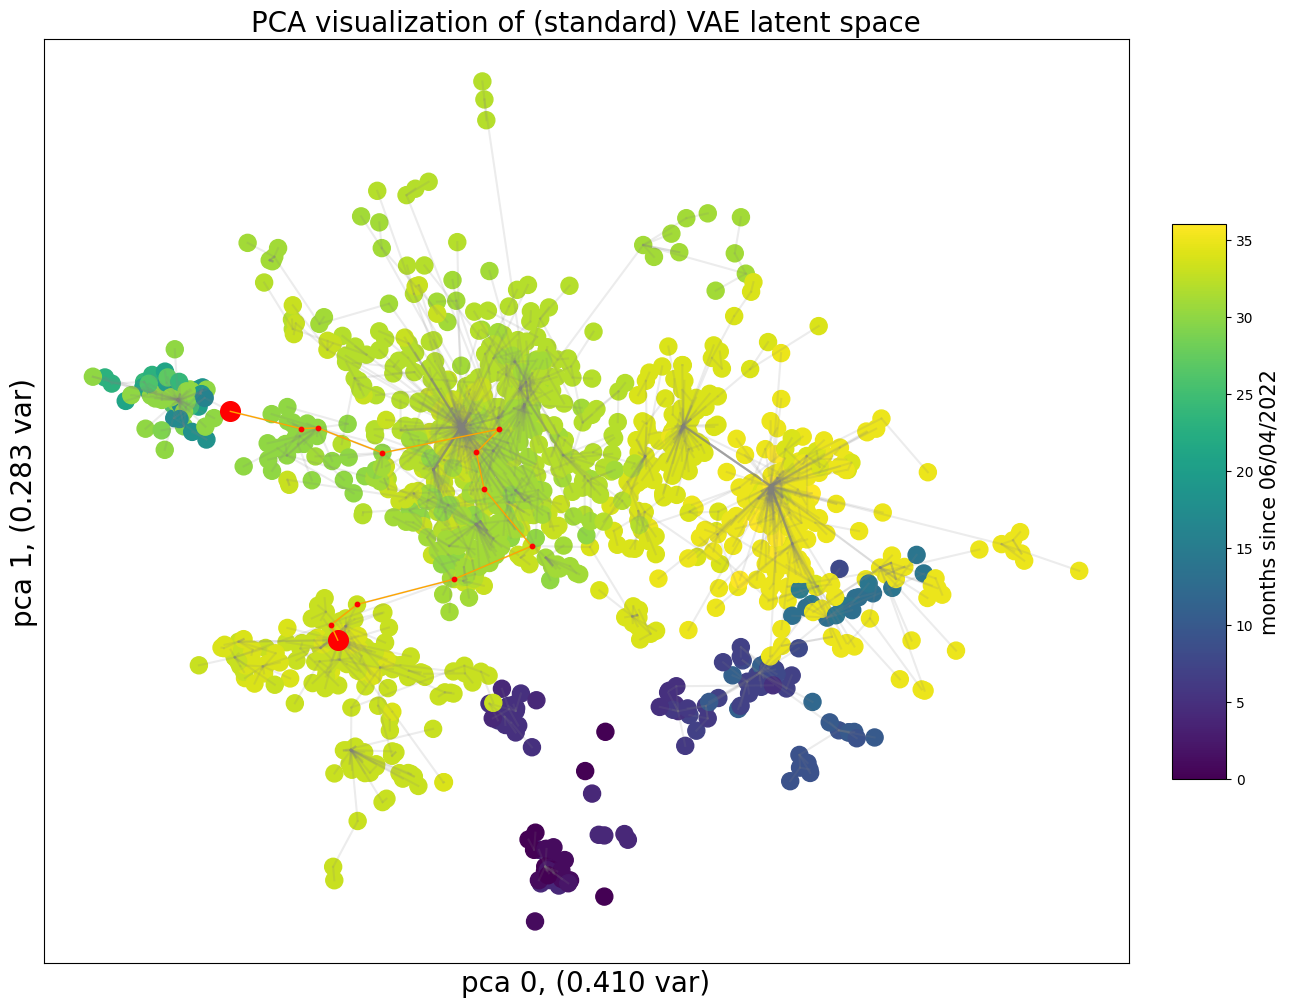

In [40]:
cmap = plt.get_cmap("gist_ncar")
colors = [cmap(x) for x in np.arange(len(indexes)) / len(indexes)]

# %matplotlib widget
# plt.ion()
# fig,ax = plt.subplots(1,1,figsize=(14,10),subplot_kw=dict(projection="3d"))
fig,ax = plt.subplots(1,1,figsize=(14,12))

# # RELATIONS
# curr = 0
# for i,arr in enumerate(indexes):
#     # ax.scatter(Z_embedded[arr,0], Z_embedded[arr,1], Z_embedded[arr, 2], label=clade_labels[arr[0]], alpha=0.6, color=colors[i], s=150)
#     ax.scatter(Z_embedded[arr,0], Z_embedded[arr,1], label=clade_labels[arr[0]], alpha=0.6, color=colors[i], s=150)
#     curr += len(arr)
# l1 = 0.1
# l2 = 0
# ax.legend(bbox_to_anchor=(l1,l2,l1+1,l2+1))

## GEODESIC
ax.scatter(Z_embedded[[G1,G2],0], Z_embedded[[G1,G2],1], color="red", s=200,zorder=10)
ax.scatter(Z_embedded[ideal_geodesic[1:-1], 0], Z_embedded[ideal_geodesic[1:-1], 1], color="red", s=10, zorder=11)
ax.plot(Z_embedded[ideal_geodesic, 0], Z_embedded[ideal_geodesic, 1], color="orange", linewidth=1, zorder=10)
##

# TIME 
# scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], Z_embedded[:,2], c=collection_dates, cmap="viridis", s=150)
scatterplot = ax.scatter(Z_embedded[uniq_indices,0], Z_embedded[uniq_indices,1], c=np.array(collection_dates)[uniq_indices], cmap="viridis", s=150)
# scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], Z_embedded[:,2], c=np.arange(Z_embedded.shape[0]), cmap="viridis", s=150)
# scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], c=np.arange(Z_embedded.shape[0]), cmap="viridis", s=150)
cax = ax.inset_axes([1.04, 0.2, 0.05, 0.6])
cbar = fig.colorbar(scatterplot, ax=ax, cax=cax, orientation='vertical')
cbar.set_label('months since 06/04/2022', fontsize=15)

ax.set_title("PCA visualization of (standard) VAE latent space",fontsize=20)
for p in pairs:
    ax.plot(Z_embedded[p,0], Z_embedded[p,1], color="gray", alpha=0.15)
    # ax.plot(Z_embedded[p,0], Z_embedded[p,1], Z_embedded[p,2], color="gray", alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel("pca 0, (%.3f var)"%(variances[0]), fontsize=20)
plt.ylabel("pca 1, (%.3f var)"%(variances[1]), fontsize=20)
# ax.set_zticks([])
plt.show()

# plotting_dict = pd.DataFrame([(x1,x2,x3,c) for (x1,x2,x3),c in zip(Z_embedded, collection_dates)], columns=["dim0","dim1","dim2","date"])
# alt.data_transformers.disable_max_rows()
# alt.Chart(plotting_dict).mark_circle(size=60).encode(
#     x='dim0',
#     y='dim1',
#     # z='dim3',
#     color='date',
#     tooltip=['dim0', 'dim1', 'date']
# ).properties(
#     width=1000,
#     height=550
# ).interactive()

## Riemannian metric

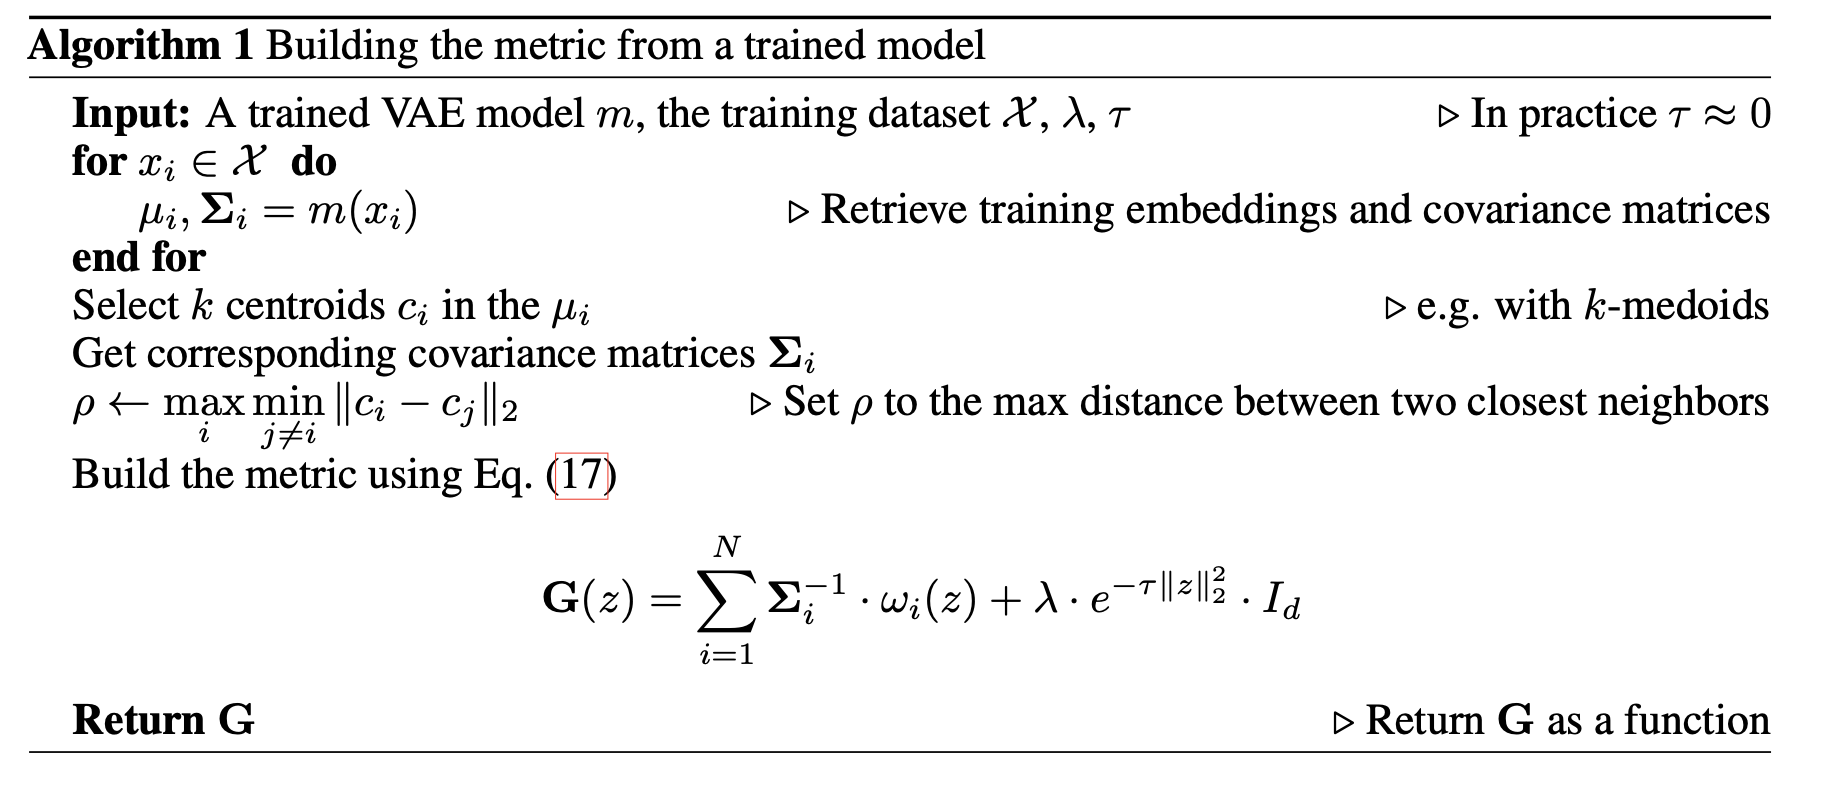

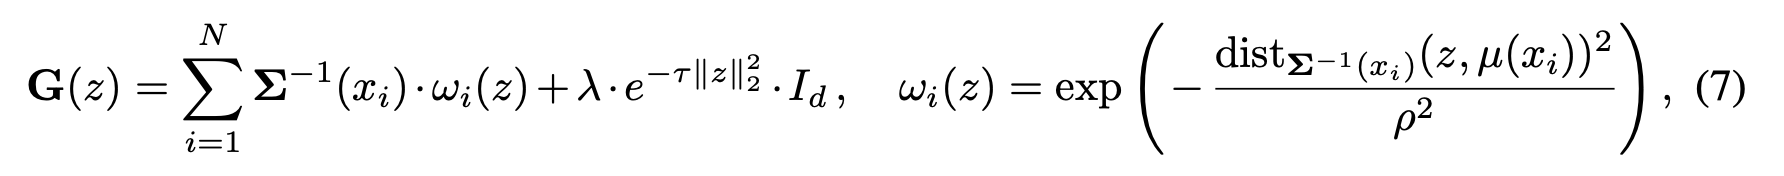

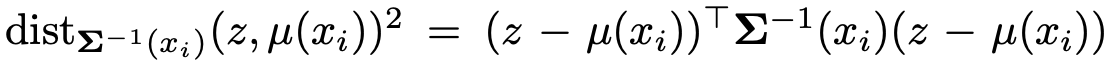

In [41]:
from sklearn_extra.cluster import KMedoids
from scipy.optimize import minimize
from scipy.optimize._numdiff import approx_derivative

from time import perf_counter

In [42]:
# # scipy implementation

# def compute_rho(mu, eps=1e-12):
#     """rho = max_i min_{j!=i} ||mu_i - mu_j||_2, vectorized."""
#     diff = mu[:, None, :] - mu[None, :, :]  # (C,C,D)
#     d = np.sqrt(np.sum(diff * diff, axis=-1))       # (C,C)
#     np.fill_diagonal(d, np.inf)
#     rho = np.max(np.min(d, axis=1) + eps)
#     return rho

# def dist_func(z, mu, sigma_inv): 
#     diff = z[:, None, :] - mu[None, :, :] # (b, 1, dim) - (1, c, dim) = (b, c, dim)
#     dist_sq = np.square(np.sum(diff * sigma_inv[None, :, :] * diff, axis=-1)) # (b, c, dim) * (1, c, dim) * (b, c, dim)
#     return dist_sq

# def omega(z, mu, sigma_inv, rho):
#     dists_sq = dist_func(z, mu, sigma_inv)
#     return np.exp(-dists_sq / np.square(rho))


# def G_batched(z, mu, sigma_var, rho, lam, tau=0, eps=1e-12):
#     sigma_inv = 1.0 / (sigma_var + eps) 
#     omegas = omega(z, mu, sigma_inv, rho) # (b,c)
#     summand = np.dot(omegas, sigma_inv) # (b,dim)
#     summand = summand + lam * np.exp(-1.0 * tau * np.sum(np.square(z), axis=-1))[:,None]
#     return summand


# def _curve_weights(k):
#     w = np.full(k, 1.0 / (k - 1))
#     w[0] *= 0.5; w[-1] *= 0.5
#     return w

# def minimize_curve(z0, z1, mu, sigma_var, rho,
#                    k=101, lam=0.0, tau=0.0,
#                    smooth=0.0, seed=None, method='L-BFGS-B', options=None, eps=1e-12, jac=None):
#     """
#     Minimize sum_i w_i * [1 / det G(z_i)] with fixed endpoints.
#     - z0, z1: (D,)
#     - mu: (C,D)
#     - sigma_var: (C,D) diagonal variances of Σ_c
#     - rho: float
#     - k: number of discretization points (len(t)=k)
#     - smooth: weight on sum ||Z[i+1]-Z[i]||^2 (optional)
#     Returns (Z_opt, scipy_result)
#     """
#     rng = np.random.default_rng(seed)
#     D = z0.shape[0]
#     t = np.linspace(0.0, 1.0, k)[:, None]
#     Z0 = (1 - t) * z0[None, :] + t * z1[None, :]
#     if k > 2:
#         Z0[1:-1] += 0.1 * rng.standard_normal((k-2, D))  # jitter

#     w = _curve_weights(k)

#     def pack(Z):  # (k,D) -> ((k-2)*D,)
#         return Z[1:-1].ravel()

#     def unpack(x):  # ((k-2)*D,) -> (k,D) with fixed endpoints
#         Z = np.empty((k, D), dtype=float)
#         Z[0] = z0
#         Z[-1] = z1
#         if k > 2:
#             Z[1:-1] = x.reshape(k-2, D)
#         return Z

#     def objective(x):
#         Z = unpack(x)
#         Gd = G_batched(Z, mu, sigma_var, rho, lam=lam, tau=tau, eps=eps)   # (k,D)
#         # 1 / det(G) computed stably: exp(-sum_d log Gd)
#         inv_det = np.exp(-np.sum(np.log(Gd + eps), axis=1))        # (k,)
#         val = np.sum(w * inv_det)
#         if smooth > 0.0:
#             diffs = Z[1:] - Z[:-1]
#             val += smooth * np.sum(diffs * diffs)
#         return val

#     def jac_func(x,*args):
#         return approx_derivative(objective, x, method="2-point", *args)

#     x0 = pack(Z0)
#     res = minimize(objective, x0, method=method, options=(options or {'maxiter': 500}), jac=jac_func)
#     # res = minimize(objective, x0, method=method, options=(options or {'maxiter': 500}), jac="2-point")
#     Z_opt = unpack(res.x)
#     return Z_opt, res

In [43]:
Z_mean, Z_logvar, recon, genome, genome_recon = utils.model_eval(vae_model, new_dataset, model_type="STANDARD")
Z_var = np.exp(Z_logvar)

Z_embedded = pca.transform(Z_mean - np.mean(Z_mean))
variances = pca.explained_variance_ratio_
tot = np.sum(variances)
print(variances)
print(f"total variance: {tot}")

c = 250
kmedoids = KMedoids(n_clusters=c, random_state=1, init="k-medoids++").fit(Z_mean[uniq_indices, :])
kmed_index = [uniq_indices[x] for x in kmedoids.medoid_indices_]

Z_mean = torch.tensor(Z_mean).to(DEVICE)
Z_var = torch.tensor(Z_var).to(DEVICE)


Recon shape
torch.Size([6368, 19110])
[0.40960428 0.28285992]
total variance: 0.6924642324447632


In [44]:
# mu = Z_mean[kmed_index,:]
# sigma = Z_var[kmed_index,:]

# t1 = perf_counter()
# rho = compute_rho(mu.cpu().numpy(), eps=1e-12)
# geodesic = minimize_curve(Z_mean[G1,:].cpu().numpy(), Z_mean[G2,:].cpu().numpy(), mu.cpu().numpy(), sigma.cpu().numpy(), rho, eps=1e-12, lam=1, k=10, smooth=1e-4)
# print(perf_counter() - t1)
# print(geodesic[1])
# geopath = geodesic[0]

In [45]:
mu = Z_mean[kmed_index,:]
sigma = Z_var[kmed_index,:]

rho = utils.compute_rho(mu)

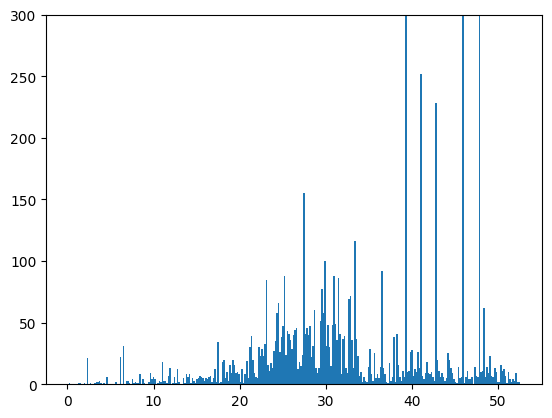

(6368,)


In [46]:
# view distribution of densities
dist = utils.G_batched(Z_mean, mu, sigma, rho, lam=1).cpu().numpy()
dist = 0.5 * np.sum(np.log(dist), axis=-1)
plt.hist(dist.flatten(),bins=300)
plt.ylim([0,300])
plt.show()

V_batched = dist
print(V_batched.shape)

31.64135392382741
10000


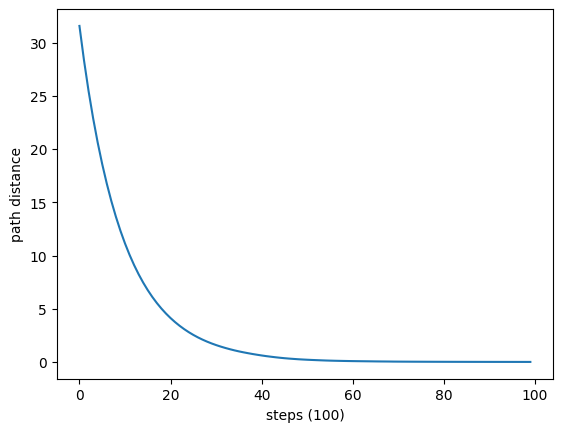

In [67]:
lam=1
s1 = 1e-3
eps=1e-8

t1 = perf_counter()
geodesic = utils.minimize_curve(Z_mean[G1,:], Z_mean[G2,:], mu, sigma, rho, lam=lam, smooth1=s1, smooth2=0.0, eps=eps, k=101, n_reps=10000, jitter=1.8)
print(perf_counter() - t1)

print(len(geodesic[1]))
losses = geodesic[1]
disp_x = range(len(losses) // 100)
disp_y = [losses[x * 100] for x in range(len(losses) // 100)]
plt.plot(disp_x, disp_y)
plt.xlabel("steps (100)")
plt.ylabel("path distance")
plt.show()

geopath = geodesic[0].detach().cpu().numpy()

In [68]:
Z_mean_np = Z_mean.cpu().numpy()
Z_var_np = Z_var.cpu().numpy()

In [69]:
# Grid over PCA_x, PCA_y -> InverseTransform -> Compute \sqrt(\det G(z)) -> Color grid with this value

# pca dimension variances on axes

# distance between point and every other (N C 2) wrt metric 

In [70]:
xmax, ymax = np.max(Z_embedded[:,:2], axis=0) + 0.5
xmin, ymin = np.min(Z_embedded[:,:2], axis=0) - 0.5

N = 100
X,Y = np.meshgrid(np.linspace(xmin, xmax, N), np.linspace(ymin, ymax, N))

space = np.concatenate((X.ravel()[:, None], Y.ravel()[:, None]), axis=-1)
space_recon = pca.inverse_transform(space) + np.mean(Z_mean_np)

space_recon_metrics_chadebec = utils.G_batched(torch.tensor(space_recon).to(DEVICE).float(), mu, sigma, rho, lam=lam, eps=eps).cpu().numpy()
space_recon_metrics_chadebec = 0.5 * np.sum(np.log(space_recon_metrics_chadebec), axis=-1).reshape(X.shape)

z_metrics_chadebec = utils.G_batched(Z_mean[uniq_indices,:], mu, sigma, rho, lam=lam, eps=eps).cpu().numpy()
z_metrics_chadebec = 0.5 * np.sum(np.log(z_metrics_chadebec), axis=-1)

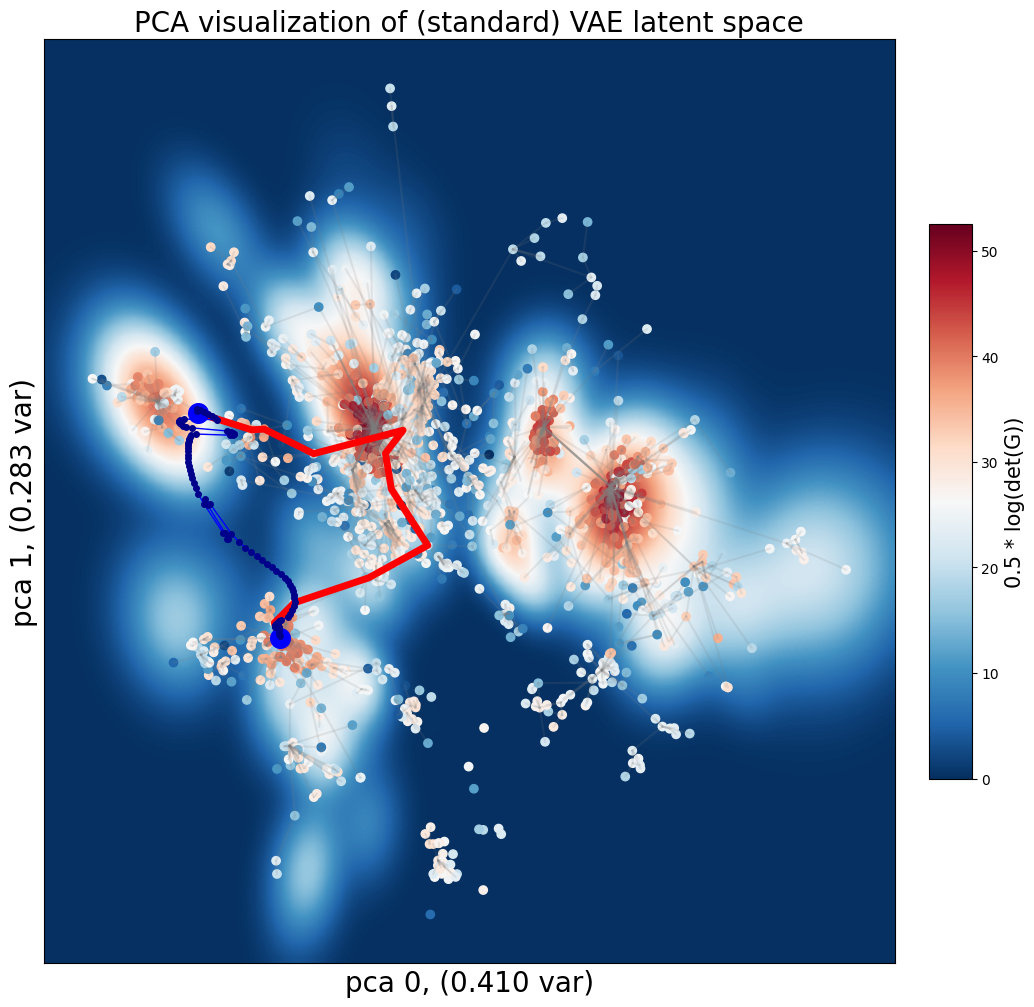

In [71]:
mu_embedded = pca.transform(mu.cpu().numpy() - np.mean(Z_mean_np))

cmap = plt.get_cmap("gist_ncar")
colors = [cmap(x) for x in np.arange(len(indexes)) / len(indexes)]

# %matplotlib widget
# plt.ioff()
# fig,ax = plt.subplots(1,1,figsize=(14,10),subplot_kw=dict(projection="3d"))
fig,ax = plt.subplots(1,1,figsize=(20,12))

# # RELATIONS
# for i,arr in enumerate(indexes):
#     # ax.scatter(Z_embedded[arr,0], Z_embedded[arr,1], Z_embedded[arr, 2], label=clade_labels[arr[0]], alpha=0.6, color=colors[i], s=150)
#     ax.scatter(Z_embedded[arr,0], Z_embedded[arr,1], label=clade_labels[arr[0]], alpha=0.6, color=colors[i], s=150)
#     curr += len(arr)
# l1 = 0.1
# l2 = 03
# ax.legend(bbox_to_anchor=(l1,l2,l1+1,l2+1))


# MANIFOLD METRIC
vmin = np.min([np.min(z_metrics_chadebec), np.min(space_recon_metrics_chadebec)])
vmax = np.max([np.max(z_metrics_chadebec), np.max(space_recon_metrics_chadebec)])
ax.scatter(Z_embedded[uniq_indices,0], Z_embedded[uniq_indices,1], c=z_metrics_chadebec, cmap=cm.RdBu_r, vmin=vmin, vmax=vmax)
# arr.scatter(Z_embedded[uniq_indices,0], Z_embedded[uniq_indices,1], color="black", alpha=0.5)
display = ax.imshow(space_recon_metrics_chadebec, interpolation='gaussian', origin='lower',
               extent=(xmin, xmax, ymin, ymax),
               cmap=cm.RdBu_r, aspect='equal', vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.xlabel("pca 0, (%.3f var)"%(variances[0]), fontsize=20)
plt.ylabel("pca 1, (%.3f var)"%(variances[1]), fontsize=20)

cax = ax.inset_axes([1.04, 0.2, 0.05, 0.6])
cbar = plt.colorbar(display, cax=cax, shrink=0.25)
cbar.set_label('0.5 * log(det(G))', fontsize=15)

# # TIME 
# scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], c=V_batched, cmap="viridis", s=150)
# # scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], c=collection_dates, cmap="viridis", s=150)
# # scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], Z_embedded[:,2], c=np.arange(Z_embedded.shape[0]), cmap="viridis", s=150)
# # scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], c=np.arange(Z_embedded.shape[0]), cmap="viridis", s=100)
# # scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], c=V_batched, cmap="viridis", s=100)
# fig.colorbar(scatterplot, ax=ax, shrink=0.5)


# ax.scatter(mu_embedded[:,0], mu_embedded[:,1], color="orange", s=50, zorder=10)

# GEODESIC
path_embedded = pca.transform(geopath - np.mean(Z_mean_np))
ax.plot(Z_embedded[ideal_geodesic, 0], Z_embedded[ideal_geodesic, 1], color="red", linewidth=5, zorder=10)
ax.scatter(path_embedded[[0,-1],0], path_embedded[[0,-1],1], s=200, zorder=11, color="blue")
ax.scatter(path_embedded[1:-1,0], path_embedded[1:-1,1], s=16, zorder=12, color="darkblue")
ax.plot(path_embedded[:,0], path_embedded[:,1], linewidth=1, zorder=10, color="blue")
# ax.scatter(path_embedded[[0,-1],0], path_embedded[[0,-1],1], path_embedded[[0,-1],2], s=200, color="red",zorder=10)
# ax.plot(path_embedded[:,0], path_embedded[:,1], linewidth=5, color="red",zorder=10)


ax.set_title("PCA visualization of (standard) VAE latent space",fontsize=20)
for p in pairs:
    ax.plot(Z_embedded[p,0], Z_embedded[p,1], color="gray", alpha=0.15)
    # ax.plot(Z_embedded[p,0], Z_embedded[p,1], Z_embedded[p,2], color="gray", alpha=0.5)

# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
plt.show()

# plotting_dict = pd.DataFrame([(x1,x2,x3,c) for (x1,x2,x3),c in zip(Z_embedded, collection_dates)], columns=["dim0","dim1","dim2","date"])
# alt.data_transformers.disable_max_rows()
# alt.Chart(plotting_dict).mark_circle(size=60).encode(
#     x='dim0',
#     y='dim1',
#     # z='dim3',
#     color='date',
#     tooltip=['dim0', 'dim1', 'date']
# ).properties(
#     width=1000,
#     height=550
# ).interactive()

In [ ]:
# lambda strongly affects behavior, directly affects the lower bound of V(*)
# centroid proportion doesn't line up with paper proportions (might just be due to fundamental diff. of space)
# K-medoids++ works better than default K-medoids for this problem
# seems to be minimizing energy by interpolating across nearest centroids, somewhat similar to NN approach of Goodfire paper
# lambda acts as a scale for the determinant which affects numerical precision of Jacobian approximations (if too low, then approximations are bad)

# TODO:
# label more

## Geodesic dist. vs. Hamming (subsampled)

In [ ]:
import pickle

c = 50
kmedoids = KMedoids(n_clusters=c, random_state=1, init="k-medoids++").fit(Z_mean[uniq_indices, :].cpu())
kmed_index = [uniq_indices[x] for x in kmedoids.medoid_indices_]

mu = Z_mean[kmed_index,:]
mu_genome = genome[kmed_index,:]

hamming = np.sum(np.not_equal(mu_genome[:,None,:], mu_genome[None,:,:]), axis=-1) # returns (c,c) matrix
hamming = hamming[np.triu_indices(c, k=1)] # extract upper half elements

l2_dists = np.sqrt(np.sum(np.square(mu[:,None,:].cpu().numpy() - mu[None,:,:].cpu().numpy()), axis=-1))
l2_dists = l2_dists[np.triu_indices(c, k=1)]

geo_dists = None
with open("../geo_losses.txt", "rb") as f:
    geo_dists = pickle.load(f)

# sanity check
print(len(hamming))
print(len(geo_dists))
print(len(l2_dists))

In [ ]:
# cbar = np.arange(len(hamming))
cbar = list(utils.flatten([[i for j in range(i+1,c)] for i in range(c)]))
alpha_ = 0.5

# # scatterplot = plt.scatter(hamming, np.log(geo_dists), alpha=alpha_, c=cbar)
# # plt.colorbar(scatterplot)
# scatterplot = plt.scatter(hamming, np.log(geo_dists), alpha=alpha_)
# plt.title("(standard) VAE hamming distance in input space vs. log(geodesic) in latent space")
# plt.xlabel("hamming dist")
# plt.ylabel("geodesic dist")
# # plt.ylim([0,0.001])
# plt.show()

# # scatterplot = plt.scatter(hamming, l2_dists, alpha=alpha_, c=cbar)
# # plt.colorbar(scatterplot)
# scatterplot = plt.scatter(hamming, l2_dists, alpha=alpha_)
# plt.title("(standard) VAE hamming distance in input space vs. l2 distance in latent space")
# plt.xlabel("hamming dist")
# plt.ylabel("l2 dist")
# plt.show()

fsize=16

fig, arr = plt.subplots(1,2,figsize=(22,10))
arr[0].scatter(hamming, np.log(geo_dists), alpha=alpha_)
arr[0].set_xlabel("hamming dist", fontsize=fsize)
arr[0].set_ylabel("geodesic dist", fontsize=fsize)
arr[0].set_title("(standard) VAE hamming distance in input space vs. log(geodesic) in latent space", fontsize=fsize)

arr[1].scatter(hamming,l2_dists,alpha=alpha_)
arr[1].set_xlabel("hamming dist", fontsize=fsize)
arr[1].set_ylabel("l2 dist", fontsize=fsize)
arr[1].set_title("(standard) VAE hamming distance in input space vs. l2 distance in latent space", fontsize=fsize)
plt.show()

In [ ]:
l2_hamming_corr = np.corrcoef(np.vstack((l2_dists, hamming)))[1,0]
geo_hamming_corr = np.corrcoef(np.vstack((geo_dists, hamming)))[1,0]

print(f"l2 vs. hamming corr. coef: {l2_hamming_corr}\n\nlog(geodesic) vs. hamming corr. coef: {geo_hamming_corr}")

### Decode Geodesic

In [ ]:
ranges = np.concatenate(indexes)
X = torch.tensor(new_dataset)
print("X shape")
print(new_dataset.shape)
print(X.shape)
# X = X.to(DEVICE)
X = X.view(X.size(0), -1).to(DEVICE)

recon = None
Z_mean = None
with torch.no_grad():
    # STANDARD
    Z_mean, Z_logvar = vae_model.encoder.forward(X)
    recon = vae_model.decoder.forward(Z_mean)
    recon = recon.view(recon.shape[0], -1).cpu()
    Z_mean = Z_mean.cpu().numpy()
    Z_var = torch.exp(Z_logvar).cpu().numpy()
converter = np.vectorize(lambda x: ALPHABET[int(x)])

In [ ]:
# avg. difference
print(np.sum(np.not_equal(genome_recon, genome)) / genome.shape[0])

In [ ]:
geodesic_recon = vae_model.decoder.forward(torch.tensor(geopath).float().to(DEVICE))
old_shape = geodesic_recon.shape
geodesic_recon = torch.argmax(geodesic_recon.view(old_shape[0], -1, 5), dim=-1).cpu().detach().numpy()
old_shape = geodesic_recon.shape
geodesic_recon = converter(geodesic_recon.ravel()).reshape(old_shape)

In [ ]:
# sanity check
print(np.sum(np.not_equal(geodesic_recon[0,:], genome[G1,:])))
print(np.sum(np.not_equal(geodesic_recon[-1,:], genome[G2,:])))

print(np.sum(np.not_equal(geodesic_recon[0,:], genome_recon[G1,:])))
print(np.sum(np.not_equal(geodesic_recon[-1,:], genome_recon[G2,:])))

In [ ]:
# remove any duplicate contiguous seq.
uniq_geodesic, ind_inv = np.unique(geodesic_recon, axis=0, return_inverse=True)
collapse_ind_inv = [ind_inv[0]]
for elem in ind_inv[1:]:
    if collapse_ind_inv[-1] != elem:
        collapse_ind_inv.append(elem)
print(ind_inv, "\n\n", collapse_ind_inv, "\n")
geodesic_recon = np.array([uniq_geodesic[x] for x in collapse_ind_inv])
print(geodesic_recon.shape)

In [ ]:
with open(f"../geodesic_recons.fasta","w") as f:
    for i in range(geodesic_recon.shape[0]):
        f.write(f">GEODESIC_{i}\n")
        f.write("".join(geodesic_recon[i,:]))
        f.write("\n")
print("done!")

### ideal geodesic vs. hamming

In [ ]:
print(uniq_inverse)

In [ ]:
print(uniq_inverse[-3])
print(uniq_inverse[-1])


print(np.sum(np.not_equal(genome[-3,:], genome[-1,:])))

In [ ]:
# leaf-ancestor set
l_a_pts = []

ubound = 5
min_ham = 5

# for v1 in uniq_indices:
count = 0
for v1 in range(new_dataset.shape[0]):
    v2 = v1
    ideal_geodesic = [v2]
    for i in range(100):
        if get_parents_dict[v2]:
            v2 = get_parents_dict[v2]
            ideal_geodesic.append(v2)
    
    tmp = [ideal_geodesic[0]]
    for x in ideal_geodesic:
        if uniq_inverse[tmp[-1]] != uniq_inverse[x]:
            tmp.append(x)
    ideal_geodesic = tmp
    
    if len(ideal_geodesic) > ubound:
        count += 1
        # print(ideal_geodesic)
        # print(ham_diffs)
        ham_diffs = [np.sum(np.not_equal(genome[ideal_geodesic[0],:], genome[ideal_geodesic[i],:])) for i in range(1,len(ideal_geodesic))]
        if ham_diffs[ubound - 1] >= min_ham:
            l_a_pts.extend([(v1, x) for x in ideal_geodesic[5:]])

print("num valid leaf-ancestor pairs:", len(l_a_pts))
print("num valid leaf endpoints:", count)

# x is leaf, y is ancestor
hamming_dists = [np.sum(np.not_equal(genome[x,:], genome[y,:])) for (x,y) in l_a_pts]
plt.hist(hamming_dists, bins=30)
plt.show()

In [ ]:
def get_ideal(leaf, ancestor):
    v1 = leaf
    v2 = v1
    ideal_geodesic = [v2]
    for i in range(100):
        if get_parents_dict[v2]:
            v2 = get_parents_dict[v2]
            ideal_geodesic.append(v2)
    
    tmp = [ideal_geodesic[0]]
    for x in ideal_geodesic:
        if uniq_inverse[tmp[-1]] != uniq_inverse[x]:
            tmp.append(x)
    ideal_geodesic = tmp

    for i in range(5,len(ideal_geodesic)):
        if ideal_geodesic[i] == ancestor:
            ideal_geodesic = ideal_geodesic[:i+1]
            break
    assert ideal_geodesic[-1] == ancestor, "geodesic end is NOT ancestor :("
    
    return ideal_geodesic

In [ ]:
X = torch.tensor(new_dataset)
print("X shape")
print(new_dataset.shape)
print(X.shape)
# X = X.to(DEVICE)
X = X.view(X.size(0), -1).to(DEVICE)
X = utils.mask_gaps(X,zero_idx=4)

recon = None
Z_mean = None
Z_embedded = None
scatterplot = None
with torch.no_grad():
    # STANDARD
    Z_mean, Z_logvar = vae_model.encoder.forward(X)
    recon = vae_model.decoder.forward(Z_mean)
    recon = recon.view(recon.shape[0], -1).cpu()
    Z_mean = Z_mean.cpu().numpy()
    Z_var = torch.exp(Z_logvar).cpu().numpy()

    # # BEDFORD
    # recon, Z_mean, Z_logvar = vae_model.forward(X)
    # recon = recon.cpu()
    # Z_mean = Z_mean.cpu().numpy()
    # Z_var = torch.exp(Z_logvar).cpu().numpy()

Z_embedded = pca.transform(Z_mean - np.mean(Z_mean))
variances = pca.explained_variance_ratio_
tot = np.sum(variances)
print(variances)
print(f"total variance: {tot}")

c = 250
kmedoids = KMedoids(n_clusters=c, random_state=1, init="k-medoids++").fit(Z_mean[uniq_indices, :])
kmed_index = [uniq_indices[x] for x in kmedoids.medoid_indices_]

Z_mean = torch.tensor(Z_mean).to(DEVICE)
Z_var = torch.tensor(Z_var).to(DEVICE)

In [ ]:
mu = Z_mean[kmed_index,:]
sigma = Z_var[kmed_index,:]
rho = utils.compute_rho(mu)


path_costs = []
for (leaf, ancestor) in l_a_pts:
    geo_indices = get_ideal(leaf, ancestor)
    ideal_geo = Z_mean[torch.tensor(geo_indices).to(DEVICE),:]

    geo_cost = utils.path_cost(ideal_geo, mu, sigma, rho, lam=0.8).cpu().numpy()

    ideal_geo = ideal_geo.cpu().numpy()
    l2_cost = utils.l2_path_len(ideal_geo)
    ang_cost = utils.cos_sim(ideal_geo)

    path_costs.append((geo_cost, l2_cost, ang_cost))

path_costs = np.array(path_costs)

In [ ]:
print(path_costs.shape)

In [ ]:
names = ["log(geodesic)","l2","angular dist."]

for i,n in enumerate(names):
    corr_coef = 0
    
    if i == 0:
        plt.scatter(hamming_dists, np.log(path_costs[:,i]), alpha=0.3)
        corr_coef = np.corrcoef(np.vstack((hamming_dists, np.log(path_costs[:,i]))))[1,0]
    else:
        plt.scatter(hamming_dists, path_costs[:,i], alpha=0.3)
        corr_coef = np.corrcoef(np.vstack((hamming_dists, path_costs[:,i])))[1,0]
    plt.title(f"VAE, hamming distance vs. ideal path {n} cost")
    plt.xlabel("hamming dist")
    plt.ylabel(n)
    plt.show()

    print(corr_coef,"\n")

In [ ]:
Z_mean = Z_mean.cpu().numpy()
Z_var = Z_var.cpu().numpy()

In [ ]:
np_l_a_pts = np.array(l_a_pts)
l2_baseline_dists = np.sqrt(np.sum(np.square(Z_mean[np_l_a_pts[:,0],:] - Z_mean[np_l_a_pts[:,1],:]), axis=-1))

plt.scatter(hamming_dists, l2_baseline_dists, alpha=0.3)
plt.title(f"VAE, hamming distance vs. interpolated path l2 cost")
plt.xlabel("hamming dist")
plt.ylabel("l2 dist")
plt.show()

print(np.corrcoef(np.vstack((hamming_dists, l2_baseline_dists)))[1,0])

In [ ]:
N = np.random.randint(0,len(l_a_pts))
n1,n2 = l_a_pts[N]
geo_indices = np.array(get_ideal(n1, n2))
print("nodes\n", n1, " ", n2, "\n\nhamming dist:")
print(np.sum(np.not_equal(genome[n1,:], genome[n2,:])))


cmap = plt.get_cmap("gist_ncar")
colors = [cmap(x) for x in np.arange(len(indexes)) / len(indexes)]

# %matplotlib widget
# plt.ion()
# fig,ax = plt.subplots(1,1,figsize=(14,10),subplot_kw=dict(projection="3d"))
fig,ax = plt.subplots(1,1,figsize=(14,10))

# # RELATIONS
# for i,arr in enumerate(indexes):
#     # ax.scatter(Z_embedded[arr,0], Z_embedded[arr,1], Z_embedded[arr, 2], label=clade_labels[arr[0]], alpha=0.6, color=colors[i], s=150)
#     ax.scatter(Z_embedded[arr,0], Z_embedded[arr,1], label=clade_labels[arr[0]], alpha=0.6, color=colors[i], s=150)
#     curr += len(arr)
# l1 = 0.1
# l2 = 0
# ax.legend(bbox_to_anchor=(l1,l2,l1+1,l2+1))

## GEODESIC
ax.scatter(Z_embedded[[n1,n2],0], Z_embedded[[n1,n2],1], color="red", s=200,zorder=10)
ax.scatter(Z_embedded[geo_indices[1:-1], 0], Z_embedded[geo_indices[1:-1], 1], color="red", s=10, zorder=11)
ax.plot(Z_embedded[geo_indices, 0], Z_embedded[geo_indices, 1], color="orange", linewidth=1, zorder=10)
##

# TIME 
# scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], Z_embedded[:,2], c=collection_dates, cmap="viridis", s=150)
scatterplot = ax.scatter(Z_embedded[uniq_indices,0], Z_embedded[uniq_indices,1], c=np.array(collection_dates)[uniq_indices], cmap="viridis", s=150)
# scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], Z_embedded[:,2], c=np.arange(Z_embedded.shape[0]), cmap="viridis", s=150)
# scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], c=np.arange(Z_embedded.shape[0]), cmap="viridis", s=150)
fig.colorbar(scatterplot, ax=ax, shrink=0.5)

ax.set_title("PCA visualization of (standard) VAE latent space",fontsize=20)
for p in pairs:
    ax.plot(Z_embedded[p,0], Z_embedded[p,1], color="gray", alpha=0.15)
    # ax.plot(Z_embedded[p,0], Z_embedded[p,1], Z_embedded[p,2], color="gray", alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_zticks([])
plt.show()

# plotting_dict = pd.DataFrame([(x1,x2,x3,c) for (x1,x2,x3),c in zip(Z_embedded, collection_dates)], columns=["dim0","dim1","dim2","date"])
# alt.data_transformers.disable_max_rows()
# alt.Chart(plotting_dict).mark_circle(size=60).encode(
#     x='dim0',
#     y='dim1',
#     # z='dim3',
#     color='date',
#     tooltip=['dim0', 'dim1', 'date']
# ).properties(
#     width=1000,
#     height=550
# ).interactive()

## Euclid vs Hamming

In [ ]:
input_dim = len(ALPHABET) * SEQ_LENGTH
# input_dim = 29903 * 5
# input_dim = 29903

# BEDFORD
# vae_model = bedford.VAE(input_dim=len(bedford.ALPHABET) * bedford.SEQ_LENGTH, latent_dim=bedford.LATENT_DIM).to(DEVICE)
# vae_model.load_state_dict(torch.load("./bedford_code/results_bedford/BEST_vae_ce_anneal.pth"))
#STANDARD
vae_model = VAE(input_dim=input_dim, latent_dim=50).to(DEVICE)
vae_model.load_state_dict(torch.load("./model_saves/standard_VAE_model_BEST.pth", weights_only=True, map_location=DEVICE))

vae_model.eval()

In [ ]:
dset = ["training", "valid", "test"]
dset = dset[0]

abspath = ".."
dataset = DNADataset(f"{abspath}/data/{dset}_spike.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])
X = torch.tensor(new_dataset)
X_in = X.view(X.size(0), -1).to(DEVICE)



# STANDARD 
Z_mean, Z_logvar = vae_model.encoder.forward(X_in)
recon = vae_model.decoder.forward(Z_mean)
Z_mean = Z_mean.detach().cpu().numpy()
# BEDFORD
# recon, Z_mean, Z_logvar = vae_model.forward(X_in)
# Z_mean = Z_mean.detach().cpu().numpy()



converter = np.vectorize(lambda x: ALPHABET[int(x)])

genome = np.dot(new_dataset, np.arange(len(ALPHABET)))
genome = np.reshape(converter(genome.ravel()), genome.shape)

genome_recon = torch.argmax(recon.view(recon.shape[0], -1, 5), dim=-1).cpu().detach().numpy()
genome_recon = np.reshape(converter(genome_recon.ravel()), genome.shape)   
genome_recon[genome == "-"] = "-"

_, uniq_indices, uniq_inverse = np.unique(genome, axis=0, return_index=True, return_inverse=True)

avg_recon_diff = np.sum(np.not_equal(genome[uniq_indices,:], genome_recon[uniq_indices,:])) / uniq_indices.shape[0]
print("avg. reconstruction error (base-pairs)\n", avg_recon_diff)

In [ ]:
Z_mean_uniq = Z_mean[uniq_indices,:]
genome_uniq = genome[uniq_indices,:]

hamming_dists = np.sum(np.not_equal(genome_uniq[:,None,:], genome_uniq[None,:,:]), axis=-1) # returns (n,n) matrix
hamming_dists = hamming_dists[np.triu_indices(uniq_indices.shape[0], k=1)] # extract upper half elements
print("done!")

euclid_dists = np.sqrt(np.sum(np.square(Z_mean_uniq[:,None,:] - Z_mean_uniq[None,:,:]), axis=-1)) # return (n,n) matrix
euclid_dists = euclid_dists[np.triu_indices(uniq_indices.shape[0], k=1)] # extract upper half elements
print("done!")

In [ ]:
plt.scatter(hamming_dists, euclid_dists, alpha=0.3)
plt.title("(standard) VAE euclidean norm in latent space vs. hamming distance in input space (validation set)")
plt.xlabel("hamming dist")
plt.ylabel("euclidean dist (L2)")
plt.show()

In [ ]:
print(np.corrcoef(np.vstack((euclid_dists, hamming_dists)))[1,0])